In [35]:
import os
from PIL import Image
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras import models
import cv2
import matplotlib.pyplot as plt

In [36]:
def prepicture(picname):
    img = Image.open('./prediction/' + picname)
    new_img = img.resize((100, 100), Image.BILINEAR)
    new_img.save(os.path.join('./prediction/', os.path.basename(picname)))

In [37]:
def read_image2(filename):
    img = Image.open('./prediction/'+filename).convert('RGB')
    return np.array(img)

In [38]:
prepicture('4.jpg')
x_test = []
x_test.append(read_image2('4.jpg'))

x_test = np.array(x_test)

x_test = x_test.astype('float32')
x_test /= 255

In [39]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.load_weights('./on_and_off.h5')

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 64)        0         
__________

### 预处理单张图像

(1, 100, 100, 3)


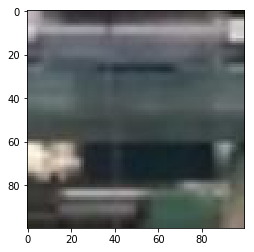

In [41]:
img_path = './prediction/4.jpg'

img = image.load_img(img_path, target_size = (100,100))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /=255

print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

In [42]:
#一个输入张量和一个输出张量列表
#提取前８层的输入
layer_outputs = [layer.output for layer in model.layers[:8]]

#创建一个模型，给定模型输入，可以返回这些输出
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [43]:
#以预测模式运行模型
#返回８个Ｎumpy数组组成的列表，每个层激活对应一个Ｎumpy数组
activations = activation_model.predict(img_tensor)

In [44]:
#第一个卷积层激活
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 98, 98, 32)


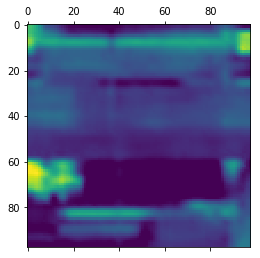

In [45]:
#将第2个通道可视化
plt.matshow(first_layer_activation[0, :, :,2], cmap='viridis')
plt.show()

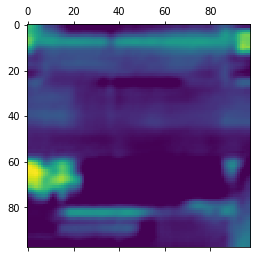

In [46]:
#将第4个通道可视化
plt.matshow(first_layer_activation[0, :, :,4], cmap='viridis')
plt.show()

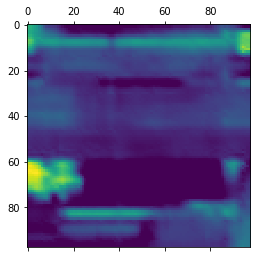

In [47]:
#将第7个通道可视化
plt.matshow(first_layer_activation[0, :, :,7], cmap='viridis')
plt.show()

### 将每个中间激活的所有通道可视化

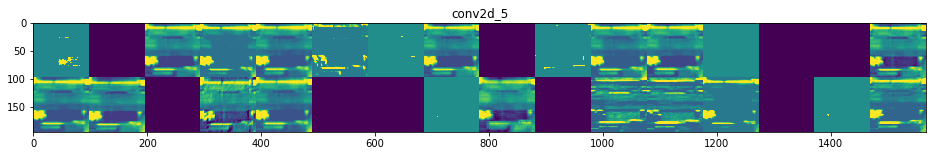

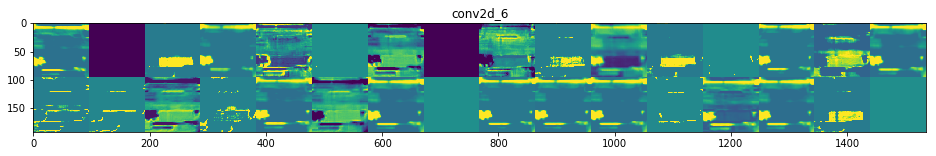

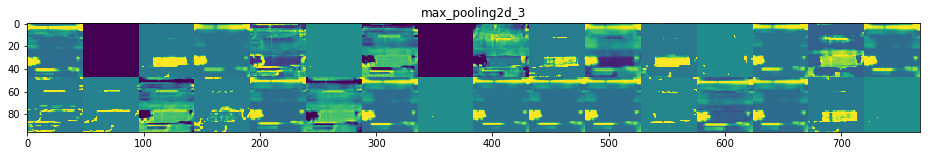

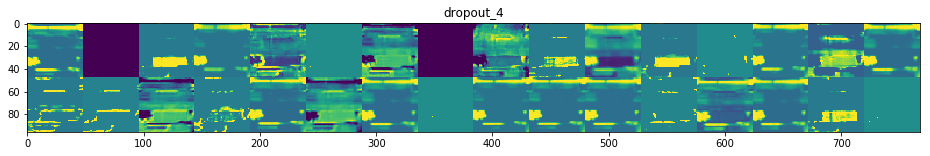

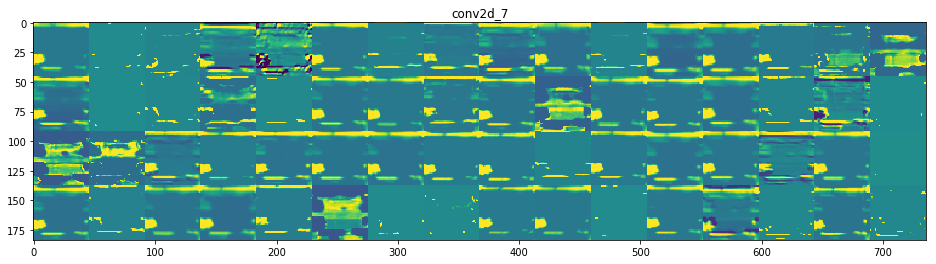

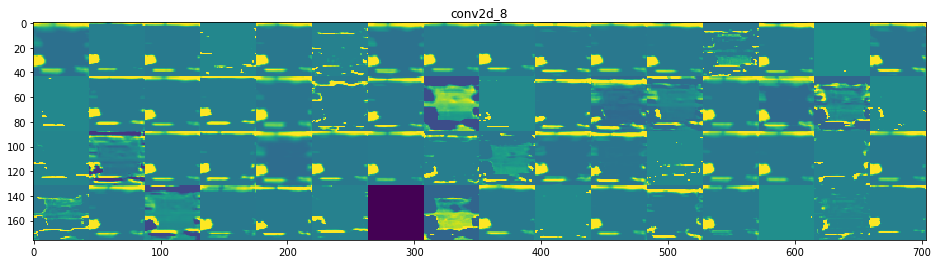

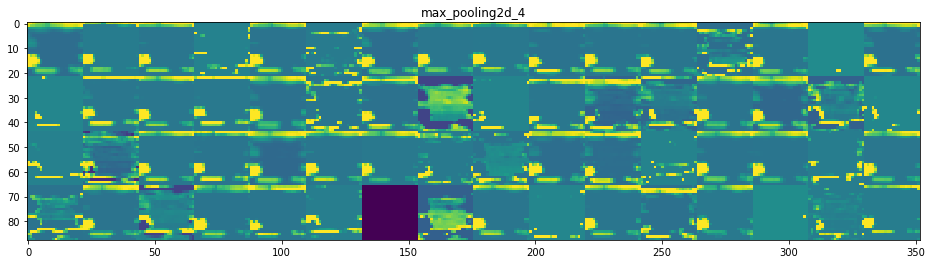

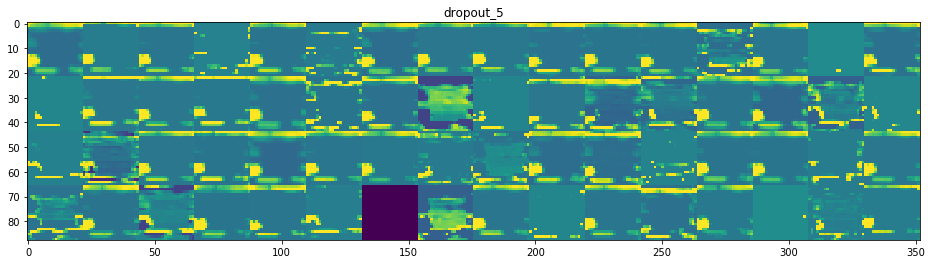

In [48]:
#层的名字
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name)
    
images_per_row = 16

#显示特征层
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]     #特征图中特征的个数
      
    size = layer_activation.shape[1]    #特征图形状为（１，size, size, n_features)
    
    n_cols = n_features // images_per_row  #在矩阵中将激活通道平铺
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols): #将每个过滤器平铺大一个大的水平网格中
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col * images_per_row + row]
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

In [49]:
classes = model.predict_classes(x_test)[0]
target = ['on', 'off']
print(target[classes])

on
